Augury
====
## Challenge
This is a good crypto challenge to start with. Use the help button to ask for a hint if you get stuck.

This file storage uses only the most secure encryption techniques.

If you are using pwntools, use ```remote("augury.pwnoh.io", 1337, ssl=True)```
```
ncat --ssl augury.challs.pwnoh.io 1337
```


## Included files
* [main.py](main.py)

## Code Analysis
The program has options to upload a file, view an uploaded file, or exit and a menu system to navigate this.

When uploading a file, the application requests a name for the file (and will prevent duplicates), a password and the contents. The contents is encoded as hexadecimal on a single line, until \n.

A keystream is created using the following function:
```python
(i * 3404970675 + 3553295105) % (2 ** 32)
```
This produces a 32-bit word, which is xor'd against every 4-byte word in the input. The keystream is seeded using a 4-byte shake128 hash of the input password. The encryption is effectively being applied OFB-mode block cipher, with an initialization vector of the hash of the password, and a known key.

![OFB mode encryption](OFB_encryption.svg.png "OFB mode encryption")
(image from https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation)

Because the secret is in the initialization vector, and the key is known, this implementation is vulnerable to a known-plaintext attack.

## Solution
First, let's retrieve the encrypted file:

In [17]:
from pwn import *
# context.log_level = "DEBUG"
with remote("augury.challs.pwnoh.io", 1337, ssl=True) as conn:
    conn.recvuntil(b"> ")
    conn.sendline(b"2")
    conn.recvuntil(b"> ")
    conn.sendline(b"secret_pic.png")

    contents = conn.recvline().decode()

[x] Opening connection to augury.challs.pwnoh.io on port 1337
[x] Opening connection to augury.challs.pwnoh.io on port 1337: Trying 2600:1f16:75:1c01::4
[+] Opening connection to augury.challs.pwnoh.io on port 1337: Done
[*] Closed connection to augury.challs.pwnoh.io port 1337


The file is a .png - the known plaintext is going to be the PNG file header.
As per [Wikipedia](https://en.wikipedia.org/wiki/PNG), the file header of a PNG is an 8 byte sequence, 0x89 0x504e47 0x0D0A 0x1A 0x0A

Using this as the known plaintext, we should be able to decode the file and recover the PNG.

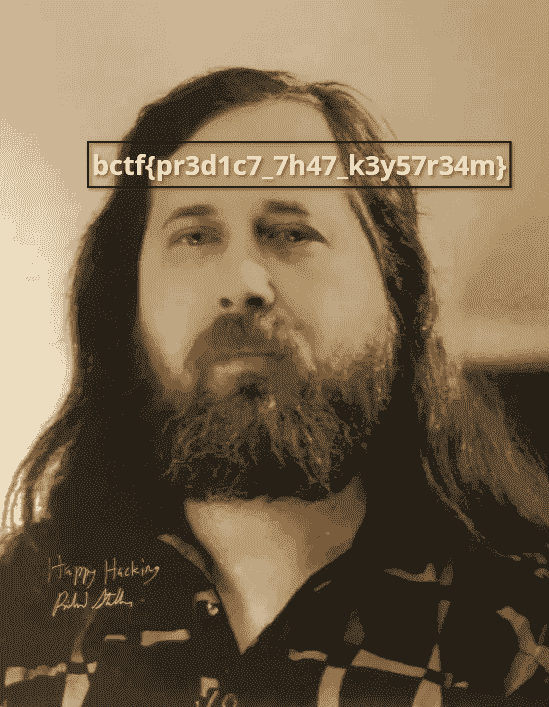

In [22]:
def generate_keystream(i):
    return (i * 3404970675 + 3553295105) % (2 ** 32)

keystream = u32(xor(secret_pic[0:4], b"\x89\x50\x4e\x47"), endianness="big")
b = bytearray(bytes.fromhex(contents))
for i in range(0, len(b), 4):
    key = keystream.to_bytes(4, byteorder="big")
    b[i + 0] ^= key[0]
    if i + 1 >= len(b):
        continue
    b[i + 1] ^= key[1]
    if i + 2 >= len(b):
        continue
    b[i + 2] ^= key[2]
    if i + 3 >= len(b):
        continue
    b[i + 3] ^= key[3]
    keystream = generate_keystream(keystream)

from IPython.display import Image
Image(b)

Flag: bctf{pr3d1c7_7h47_k3y57r34m}